## Classification of Log Data

### Facies Classification Example

Here we'll look to
* Classify well curves
* Compute elastic properties
* Cross plot
* Identify trends and clusters
* Classify based on elastic properties

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt

### Load Well Data

Public well data as part of course excersises 'Seismic Attribute Analysis' referenced by TLE article:

In [3]:
well_a_data = pd.read_csv('well_2.txt',delim_whitespace=True)
well_a_data.columns = well_a_data.columns.str.upper()
well_a_data['DEPTH(M)'] = well_a_data.round({'DEPTH(M)': 1})
print(well_a_data.iloc[:3])

   DEPTH(M)      VP      VS     RHO       GR    NPHI
0    2013.3  2.2947  0.8769  1.9972  91.8785  0.4908
1    2013.4  2.2967  0.9430  2.0455  86.8004  0.4833
2    2013.6  2.2904  0.9125  2.1122  86.0021  0.4474


In [4]:
well_a_sw = pd.read_csv('well_2_sats.txt',delim_whitespace=True)
well_a_sw.columns = well_a_sw.columns.str.upper()
print(well_a_sw.keys())
well_a_sw['DEPTH(M)'] = well_a_sw['DEPTH(M)']+24 # depth adjustment to match logs
well_a_sw['DEPTH(M)'] = well_a_sw.round({'DEPTH(M)': 1})
print(well_a_sw.iloc[:3])

Index(['DEPTH(M)', 'SW_DEEP', 'SW_X'], dtype='object')
   DEPTH(M)  SW_DEEP  SW_X
0    2012.4      1.0   1.0
1    2012.5      1.0   1.0
2    2012.7      1.0   1.0


#### Merge log curves to single dataframe

In [5]:
well_a_data = well_a_data.merge(well_a_sw, how='left', on='DEPTH(M)')
print(well_a_data.iloc[:3])

   DEPTH(M)      VP      VS     RHO       GR    NPHI  SW_DEEP  SW_X
0    2013.3  2.2947  0.8769  1.9972  91.8785  0.4908      1.0   1.0
1    2013.4  2.2967  0.9430  2.0455  86.8004  0.4833      1.0   1.0
2    2013.6  2.2904  0.9125  2.1122  86.0021  0.4474      1.0   1.0


#### These are the basic measured properties from geophysical logging

#### Adjust Units for Vp and Vs to m/s

Get the velocity curves in standard metric units

In [6]:
well_a_data['VP'] = well_a_data['VP']*1000
well_a_data['VS'] = well_a_data['VS']*1000

#### Calculate Additional Log Curves (Feature Engineering?)
1. VP:VS Ratio, the ratio of measured compressional and shear velocities
* Impedance = (VP * RHO), the productd of compressional velocity and density
* Volume of Shale VSH = 0.33(2 ^(2*[(GR - GR0) / (GR100 - GR0)]) - 1)
  * GR0 - Gamma reading in clean sand (min)
  * GR100 - Gamma reading in shale-y-est shale (max)
* Porosity Phi = density matrix - density form log response / density of matrix - density of fluid
* Add columns to the DataFrame
* Clean up column names

|Lithology	| Density (gr/cm3) | Fluid | Density (gr/cm3) |
| :-: |:--: | |:-: | :--: |
| Sandstone	| 2.644	| Fresh Water	| 1.0 |
| Limestone	| 2.710	| Salt Water	| 1.15 |
| Dolomite	| 2.877	| Methane	| 0.423 |
| Anhydrite	| 2.960	| Oil	| 0.8 |

In [7]:
# Impedance
well_a_data['ZP'] = well_a_data['VP']*well_a_data['RHO']
# VP/VS
well_a_data['VPVS'] = well_a_data['VP']/well_a_data['VS']
# Calculate VSH
IGR = ((well_a_data['GR']-well_a_data['GR'].min())/(well_a_data['GR'].max()-well_a_data['GR'].min()))
well_a_data['VSH'] = 0.33*((2**(2*IGR)-1))
# Calculate Phi Total Porosity, using sandstone matrix and Salt Water
well_a_data['PHI'] = (2.64-well_a_data['RHO'])/(2.64-1.0)

# Calculate VCLAY
#well_a_data['VCL'] = (0.5*well_a_data['VSH'])/(1.5-well_a_data['VSH'])

well_a_data.rename(columns={'SW_DEEP': 'SW'}, inplace=True)
well_a_data.rename(columns={'DEPTH(M)': 'DEPTH'}, inplace=True)
well_a_data = well_a_data.dropna()
print(well_a_data.iloc[:3])

    DEPTH      VP     VS     RHO       GR    NPHI   SW  SW_X          ZP  \
0  2013.3  2294.7  876.9  1.9972  91.8785  0.4908  1.0   1.0  4582.97484   
1  2013.4  2296.7  943.0  2.0455  86.8004  0.4833  1.0   1.0  4697.89985   
2  2013.6  2290.4  912.5  2.1122  86.0021  0.4474  1.0   1.0  4837.78288   

       VPVS       VSH       PHI  
0  2.616832  0.324189  0.391951  
1  2.435525  0.273974  0.362500  
2  2.510027  0.266438  0.321829  


In [8]:
plot_curves = ['VP','VS','RHO','ZP','VPVS','PHI','VSH']
well_a_data[['VP','VS','RHO','GR','VSH','ZP','VPVS','PHI']].describe()


,VP,VS,RHO,GR,VSH,ZP,VPVS,PHI
count,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000
mean,2802.361963,1267.183899,2.204079,75.654446,0.191756,6179.297162,2.259774,0.265805
std,366.057434,271.379313,0.077687,14.871693,0.134299,852.873898,0.254774,0.047370
min,1964.700000,688.800000,1.747800,49.898000,0.008033,3953.958750,1.662906,0.045793
25%,2452.050000,1006.350000,2.168500,63.423300,0.088160,5408.963590,2.059355,0.236067
50%,2830.800000,1280.400000,2.203600,71.248600,0.142926,6186.275040,2.197106,0.266098
75%,3127.000000,1499.750000,2.252850,86.812800,0.274092,6933.823900,2.455870,0.287500
max,3747.500000,2000.200000,2.564900,136.512800,0.990000,8292.842750,3.234734,0.544024


#### Set constants

In this single well example the depth range being considered is fixed.  
A more generalized solution may use widgets to make the depths range interactive.

In [9]:
depth_start = 2100
depth_stop = 2400
sand_cutoff = 0.18

In [10]:
logs = well_a_data
# Select a subset of the DataFrame based on depth range
logs = logs.ix[(logs.DEPTH>=depth_start) & (logs.DEPTH<=depth_stop)]

# Identify index positions within the DataFrame that meet labeling criteria
brine_sand = ((logs.VSH <= sand_cutoff) & (logs.SW >= 0.9))
oil_sand = ((logs.VSH <= sand_cutoff) & (logs.SW < 0.9))
shale = (logs.VSH > sand_cutoff)

In [11]:
temp_lfc = np.zeros(np.shape(logs.GR))
temp_lfc[brine_sand.values] = 1    # LFC will be 1 when ssb (brine sand flag) is True
temp_lfc[oil_sand.values] = 2      # LFC will be 2 when sso (oil sand flag) is True
temp_lfc[shale.values] = 4         # LFC will be 4 when sh (shale flag) is True
logs['LFC'] = temp_lfc             # Copy the temporary log temp_lfc into the DataFrame with name `LFC`


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
import matplotlib.colors as colors
#      0=undef   1=bri  2=oil   3=gas 4=shale
ccc = ['pink','blue','green','red','grey']
cmap_facies = colors.ListedColormap(ccc[0:len(ccc)], 'indexed')

(1613, 100)


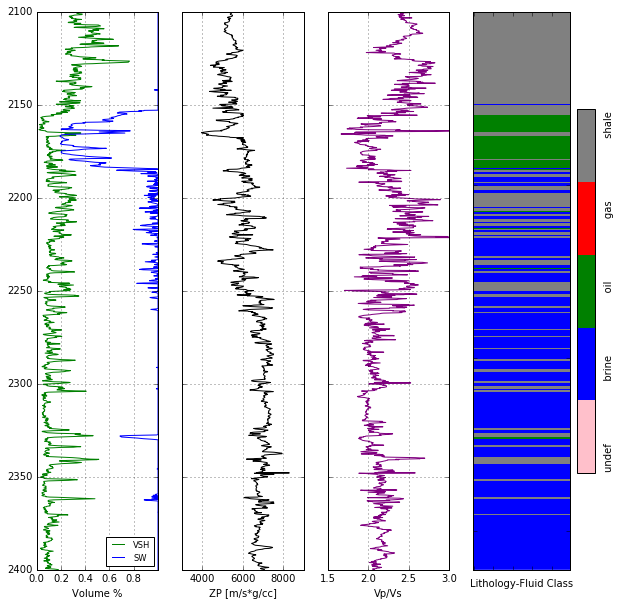

In [13]:
ztop=depth_start; zbot=depth_stop
figx = 10
figy = 10
ll=logs.ix[(logs.DEPTH>=ztop) & (logs.DEPTH<=zbot)]

cluster=np.repeat(np.expand_dims(ll['LFC'].values,1), 100, 1)
print(cluster.shape)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(figx, figy))
ax[0].plot(ll.VSH, ll.DEPTH, 'g', label='VSH')
ax[0].plot(ll.SW, ll.DEPTH, 'b', label='SW')
ax[1].plot(ll.ZP, ll.DEPTH, '-', color='k')
ax[2].plot(ll.VPVS, ll.DEPTH, '-', color='purple')
im=ax[3].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)

cbar=plt.colorbar(im, ax=ax[3])
#cbar.set_label('0=undef,1=brine,2=oil,3=gas,4=shale')
#cbar.set_ticks(range(1,4)); cbar.set_ticklabels(range(1,4))
cbar.set_label((figy*'  ').join(['undef', 'brine', 'oil', 'gas', 'shale']))
cbar.set_ticks(np.arange(0,5,5)); cbar.set_ticklabels('')
#loc = np.arange(0,5,5/float(4))
#cbar.set_ticks(loc)
#cbar.set_ticklabels(ccc)

for i in range(len(ax)-1):
    ax[i].set_ylim(ztop,zbot)
    ax[i].invert_yaxis()
    ax[i].grid()
    ax[i].locator_params(axis='x', nbins=len(ax))
ax[0].legend(fontsize='small', loc='lower right')
ax[0].set_xlabel("Volume %"), ax[0].set_xlim(0,1) , ax[0].set_xticks(np.arange(0,1,0.2))
ax[1].set_xlabel("ZP [m/s*g/cc]"), ax[1].set_xlim(3000,9000)
ax[2].set_xlabel("Vp/Vs"),         ax[2].set_xlim(1.5,3)
ax[3].set_xlabel('Lithology-Fluid Class')
ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([]); ax[3].set_xticklabels([])

plt.show()
#plt.savefig("log.png", dpi=250)

### Log Correlations and Anomalies

Here we'll look at
* Which logs correlate
* Background trends
* Anomalies which may be features of interest
* Isolating the anomalies to investigate their properties

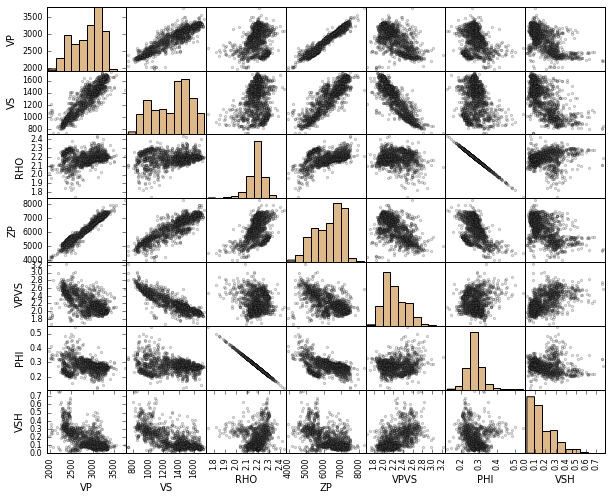

In [14]:
axes = pd.tools.plotting.scatter_matrix(logs[plot_curves], marker='.', c='grey', alpha=0.2,
                                        diagonal='hist',hist_kwds={'color':['burlywood']}, figsize=(10,8)) 
plt.show()  

### A closer look at the Elastic Log Data: Zp and Vp/Vs

Below we can observe the distribution of elastic properties for the interval of investigation.  
VpVs is weighted to the lower end values which often contain sand dominated lithologies.
P-impedance (ZP) is weighted to the higher values, a combination of faster velocity and either more dense or less porous intervals.  

#### Cross plotting Vp/Vs and Zp we can observe trends in the elastic property space

There are perhaps 2 trends and 3 clusters.  
Highlighting the points which are associated with the oil bearing sandstones, we can observe that the majority of the points fall in the lower Vp/Vs and lower Zp value range. 



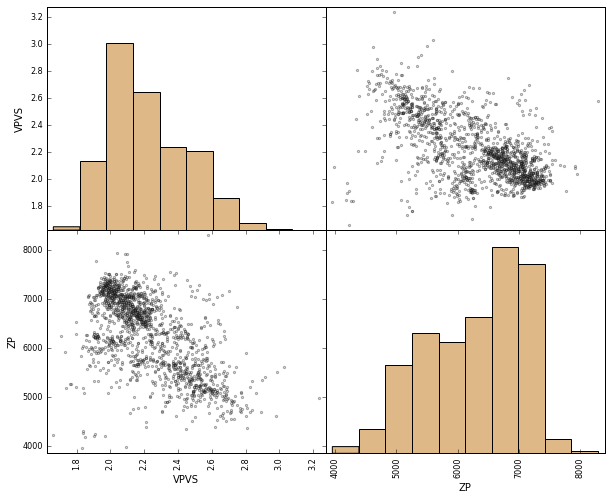

In [15]:
axes = pd.tools.plotting.scatter_matrix(logs[['VPVS','ZP']],
                                        marker='.', c='grey', alpha=0.3,diagonal='hist',
                                        hist_kwds={'color':['burlywood']}, figsize=(10,8)) 
plt.show()

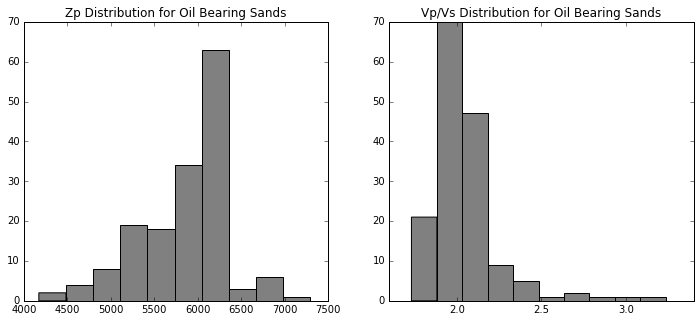

In [16]:
fig = plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
plt.hist(logs['ZP'][oil_sand.values],color='grey')
plt.title('Zp Distribution for Oil Bearing Sands')

ax=fig.add_subplot(1,2,2)
plt.hist(logs['VPVS'][oil_sand.values],color='grey')

plt.title('Vp/Vs Distribution for Oil Bearing Sands')
plt.show()

#### Elastic Property Distribution Oil Bearing Sands

Histograms of the elastic properties (Zp and Vp/Vs ratios) within the oil bearing sands show the majority of data points fall in discrete ranges.  For ZP the majority of the oil bearing sands can be captured in the range 5000 - 6500.  Vp/Vs ratio shows that the majority of the oil bearing data points can be identified below 2.3

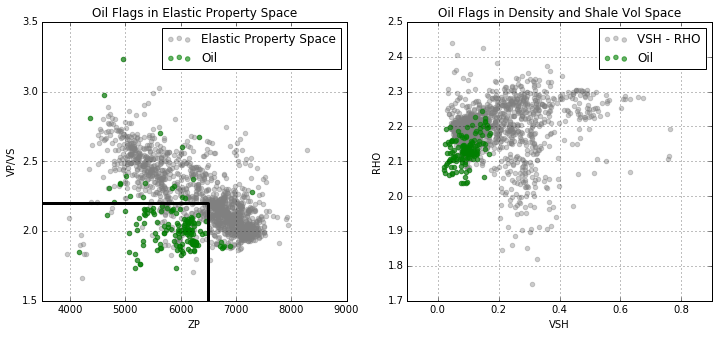

In [17]:
fig = plt.figure(figsize=(12,5)) 

ax = fig.add_subplot(1,2,1)
plt.scatter(logs['ZP'],logs['VPVS'], alpha=0.4, color='grey',label='Elastic Property Space')
plt.scatter(logs['ZP'][oil_sand.values],logs['VPVS'][oil_sand.values], color='g', alpha=0.6,label='Oil')
# Zone highlight
plt.plot([3500,6500,6500],[2.2,2.2,1.5], color='k', linewidth='3')
plt.xlabel('ZP')
plt.ylabel('VP/VS')
ax.set_xlim(3500,9000)
ax.set_ylim(1.5,3.5)

plt.title('Oil Flags in Elastic Property Space')
ax.legend()
ax.grid()

ax = fig.add_subplot(1,2,2)
plt.scatter(logs['VSH'],logs['RHO'], alpha=0.4, color='grey', label='VSH - RHO')
plt.scatter(logs['VSH'][oil_sand.values],logs['RHO'][oil_sand.values], color='g', alpha=0.6, label='Oil')

plt.xlabel('VSH')
plt.ylabel('RHO')
plt.title('Oil Flags in Density and Shale Vol Space')
ax.legend()
ax.grid()

plt.show()

#### Classification from Elastic Properties

Identifying sandstone reservoirs when log properties are available is great.  
In Exploration and early Production settings, this information is not as readily available as desired.  

Inverting seismic data for elastic properties and property ratios is a usefull tool for predicting the presence and potential
quality of sandstone reservoirs over large areas where direct samples (wells) are not available.

Below we'll show how basic cutoffs in the P-Impedance and VP/VS ratio space will indicate reservoir prone intervals.  These intervals may or not be hydrocarbon charged, in this example it is suggested from the water saturation (SW) that they contain hydrocarbons.

In [18]:
temp_lfc = np.zeros(np.shape(logs.GR))
res_elast_props = ((logs.VPVS <= 2.2) & (logs.ZP < 6500))
temp_lfc[res_elast_props.values] = 2 

temp_lfc[brine_sand.values] = 1    # LFC will be 1 when ssb (brine sand flag) is True

temp_lfc[shale.values] = 4         # LFC will be 4 when sh (shale flag) is True
logs['LFC_Elast'] = temp_lfc             # Copy the temporary log temp_lfc into the DataFrame with name `LFC`
logs.describe()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,DEPTH,VP,VS,RHO,GR,NPHI,SW,SW_X,ZP,VPVS,VSH,PHI,LFC,LFC_Elast
count,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000
mean,2250.093242,2872.169188,1315.187415,2.186907,73.533027,0.332968,0.930471,0.987609,6286.482216,2.221716,0.172470,0.276276,2.200868,2.168630
std,86.669568,327.288939,244.309301,0.072000,13.691697,0.059735,0.187984,0.042851,783.837603,0.232139,0.119672,0.043902,1.402081,1.429079
min,2100.000000,1964.700000,735.300000,1.747800,51.886200,0.181100,0.192000,0.701000,3953.958750,1.662906,0.018771,0.122256,1.000000,0.000000
25%,2175.400000,2590.800000,1101.600000,2.156100,62.937900,0.288100,1.000000,1.000000,5646.500640,2.038622,0.084980,0.252866,1.000000,1.000000
50%,2250.100000,2952.600000,1379.100000,2.191600,68.430800,0.313000,1.000000,1.000000,6452.212160,2.164773,0.122425,0.273415,1.000000,1.000000
75%,2325.200000,3145.900000,1509.400000,2.225300,83.687300,0.365900,1.000000,1.000000,6952.176000,2.397061,0.245115,0.295061,4.000000,4.000000
max,2399.900000,3747.500000,1738.200000,2.439500,124.583900,0.526200,1.000000,1.000000,8292.842750,3.234734,0.764195,0.544024,4.000000,4.000000


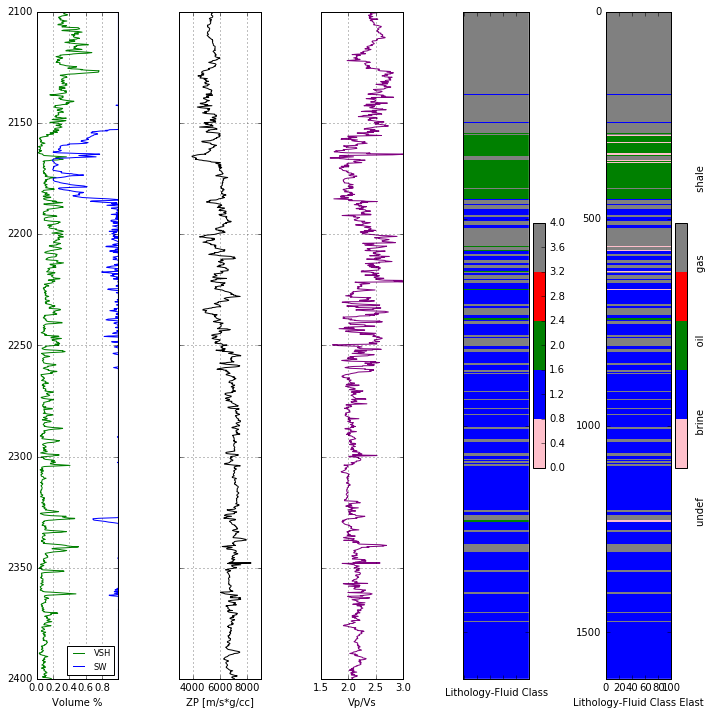

In [19]:
ztop=depth_start; zbot=depth_stop
figx = 10
figy = 10
ll=logs.ix[(logs.DEPTH>=ztop) & (logs.DEPTH<=zbot)]

cluster=np.repeat(np.expand_dims(ll['LFC'].values,1), 100, 1)
clusterb=np.repeat(np.expand_dims(ll['LFC_Elast'].values,1), 100, 1)

f, ax = plt.subplots(nrows=1, ncols=5, figsize=(figx, figy))
ax[0].plot(ll.VSH, ll.DEPTH, 'g', label='VSH')
ax[0].plot(ll.SW, ll.DEPTH, 'b', label='SW')
ax[1].plot(ll.ZP, ll.DEPTH, '-', color='k')
ax[2].plot(ll.VPVS, ll.DEPTH, '-', color='purple')
#im=ax[3].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)
im_lfc = ax[3].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)
im_lfc_elast = ax[4].imshow(clusterb, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)
cbar_lfc=plt.colorbar(im_lfc, ax=ax[3])
cbar=plt.colorbar(im_lfc_elast, ax=ax[4])
#cbar.set_label('0=undef,1=brine,2=oil,3=gas,4=shale')
#cbar.set_ticks(range(1,4)); cbar.set_ticklabels(range(1,4))
cbar.set_label((figy*'  ').join(['undef', 'brine', 'oil', 'gas', 'shale']))
cbar.set_ticks(np.arange(0,5,5)); cbar.set_ticklabels('')
#loc = np.arange(0,5,5/float(4))
#cbar.set_ticks(loc)
#cbar.set_ticklabels(ccc)

for i in range(len(ax)-2):
    ax[i].set_ylim(ztop,zbot)
    ax[i].invert_yaxis()
    ax[i].grid()
    ax[i].locator_params(axis='x', nbins=len(ax))
ax[0].legend(fontsize='small', loc='lower right')
ax[0].set_xlabel("Volume %"), ax[0].set_xlim(0,1) , ax[0].set_xticks(np.arange(0,1,0.2))
ax[1].set_xlabel("ZP [m/s*g/cc]"), ax[1].set_xlim(3000,9000)
ax[2].set_xlabel("Vp/Vs"),         ax[2].set_xlim(1.5,3)
ax[3].set_xlabel('Lithology-Fluid Class')
ax[4].set_xlabel('Lithology-Fluid Class Elast')
ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([]); ax[3].set_xticklabels([])

plt.tight_layout()
plt.show()
#plt.savefig("log.png", dpi=250)

### Where to take this..

1. Write plot func that handles plotting log curves - a good example might be to start from Enthought github - ian follows the guy, matt something.
2. The task should then be discussion and demonstration of value extraction from data.
    * Establish the use of elastic properties for identifying zones of interst.
    * Use clustering to show automated classification of zones (un-supervised)
    * Use supervised classification to demonstrate trained model and automated labeling of lithologies.
    

### Classification - Zones of Interest

Initially we've classified the zones of interest (sandstones likely saturated with oil) based on cuttoffs from log measurements.  Now we'll investigate unsupervised classfication based on clustering in varying feature space.  Then we'll build a predictive model to automatically classify the zones and compare against labeling based on known cutoffs.

1. Classify based on clustering from different feature sets.
2. Build predictive model to automate zone classification, compare against known labels.

3. Comment on predictive power for use in data driven decision making.  Reduce risk in pre-drill valuation for resource capture, exploitation and development optimization.

In [20]:
X = logs[['ZP','VPVS']].values


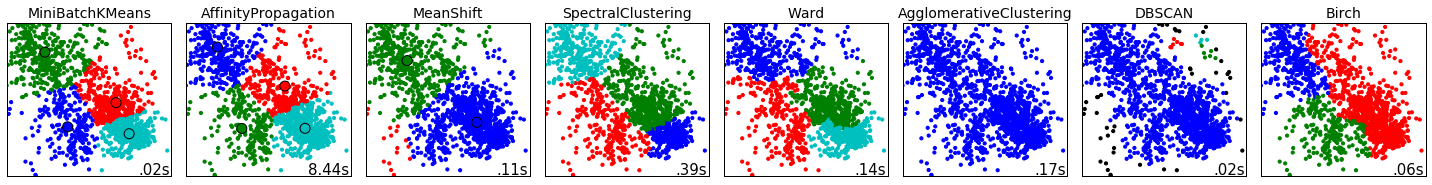

In [30]:
import time
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler


# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times

VPVS = X

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN', 'Birch']

plt.figure(figsize=(len(clustering_names) * 2 + 4, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

datasets = [VPVS]
for i_dataset, dataset in enumerate(datasets):
    X = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=4)
    ward = cluster.AgglomerativeClustering(n_clusters=4, linkage='ward',
                                           connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=4,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=4,
        connectivity=connectivity)

    birch = cluster.Birch(n_clusters=4)
    clustering_algorithms = [
        two_means, affinity_propagation, ms, spectral, ward, average_linkage,
        dbscan, birch]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=14)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
plt.tight_layout()
plt.show()

#### Clustering Algorithms

Looking at the distribution of data and comparing to what a person may intuitively select for clusters the Birch, KMeans, Affinity Propagation and Spectral Clustering algorithms all show reasonable results.

Agglomerative Clustering and DBSCAN could be improved with adjustments to their parameterization.  Ward introduces irregular decision boundaries that if related to a reasonable physical basis would be interesting to investigate at a later date.

Birch gets us 80% of the way there with the 3rd fastest execution time, so we'll proceed with that.

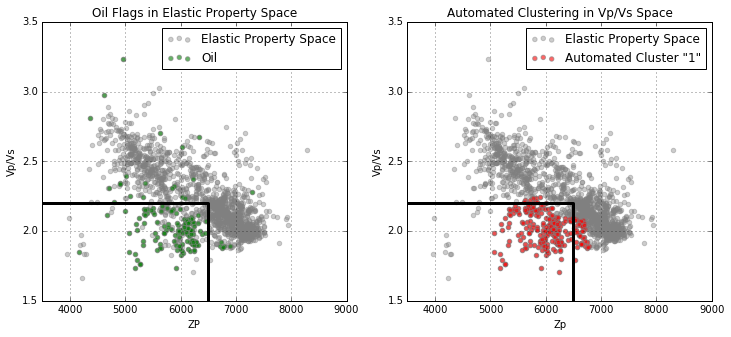

In [46]:
fig = plt.figure(figsize=(12,5)) 
ax = fig.add_subplot(1,2,1)
plt.scatter(logs['ZP'],logs['VPVS'], alpha=0.4, color='grey',label='Elastic Property Space')
plt.scatter(logs['ZP'][oil_sand.values],logs['VPVS'][oil_sand.values], color='g', alpha=0.6,label='Oil', edgecolor='grey')
# Zone highlight
plt.plot([3500,6500,6500],[2.2,2.2,1.5], color='k', linewidth='3')
plt.xlabel('ZP')
plt.ylabel('Vp/Vs')
ax.set_xlim(3500,9000)
ax.set_ylim(1.5,3.5)
plt.title('Oil Flags in Elastic Property Space')
ax.legend()
ax.grid()

ax = fig.add_subplot(1,2,2)
plt.scatter(logs['ZP'],logs['VPVS'], alpha=0.4, color='grey',label='Elastic Property Space')
plt.scatter(logs['ZP'][y_pred==1],logs['VPVS'][y_pred==1], color='r', edgecolor='grey', alpha=0.6, label='Automated Cluster "1"')
plt.plot([3500,6500,6500],[2.2,2.2,1.5], color='k', linewidth='3')
ax.set_xlim(3500,9000)
ax.set_ylim(1.5,3.5)
plt.xlabel('Zp')
plt.ylabel('Vp/Vs')
plt.title('Automated Clustering in Vp/Vs Space')
ax.legend()
ax.grid()

plt.show()

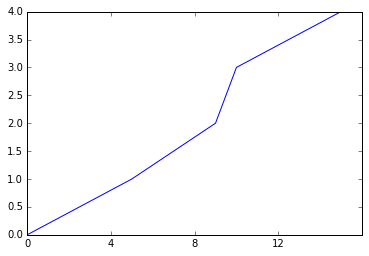

In [22]:
x = [0,5,9,10,15]
y = [0,1,2,3,4]
plt.plot(x,y)
plt.xticks(np.arange(min(x), max(x)+1, 4.0))
plt.show()